# Preprocessing

## Data exploration

In [54]:
import numpy as np
import pandas as pd

# Import tools needed for visualization
from IPython.display import Image
from sklearn.tree import export_graphviz
import pydotplus
from sklearn.tree import export_graphviz
import seaborn as sns
import matplotlib.pyplot as plt

# Models & Processing
from sklearn import preprocessing
from sklearn.pipeline import Pipeline
from collections import Counter
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.linear_model import LinearRegression,LogisticRegression
from sklearn.tree import DecisionTreeRegressor,DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA
from sklearn.ensemble import StackingClassifier
from xgboost import XGBClassifier

# Evaluation Metrics
from sklearn import metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, ConfusionMatrixDisplay, precision_score, recall_score, f1_score, classification_report, roc_curve, plot_roc_curve, auc, precision_recall_curve, plot_precision_recall_curve, average_precision_score
from sklearn.model_selection import cross_val_score
from sklearn.metrics import matthews_corrcoef

# Tuning of Model
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

# Imblearn
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler


In [55]:
df = pd.read_csv("https://raw.githubusercontent.com/bryanmylee/smu-cs421/master/hotel_bookings.csv")

In [56]:
df.head()

hotel  is_canceled  ...  reservation_status  reservation_status_date
0  Resort Hotel            0  ...           Check-Out               2015-07-01
1  Resort Hotel            0  ...           Check-Out               2015-07-01
2  Resort Hotel            0  ...           Check-Out               2015-07-02
3  Resort Hotel            0  ...           Check-Out               2015-07-02
4  Resort Hotel            0  ...           Check-Out               2015-07-03

[5 rows x 32 columns]

In [57]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 32 columns):
 #   Column                          Non-Null Count   Dtype  
---  ------                          --------------   -----  
 0   hotel                           119390 non-null  object 
 1   is_canceled                     119390 non-null  int64  
 2   lead_time                       119390 non-null  int64  
 3   arrival_date_year               119390 non-null  int64  
 4   arrival_date_month              119390 non-null  object 
 5   arrival_date_week_number        119390 non-null  int64  
 6   arrival_date_day_of_month       119390 non-null  int64  
 7   stays_in_weekend_nights         119390 non-null  int64  
 8   stays_in_week_nights            119390 non-null  int64  
 9   adults                          119390 non-null  int64  
 10  children                        119386 non-null  float64
 11  babies                          119390 non-null  int64  
 12  meal            

In [58]:
df.shape

(119390, 32)

In [59]:
print("Number of NaN in each columns:")
print(df.isnull().sum())

Number of NaN in each columns:
hotel                                  0
is_canceled                            0
lead_time                              0
arrival_date_year                      0
arrival_date_month                     0
arrival_date_week_number               0
arrival_date_day_of_month              0
stays_in_weekend_nights                0
stays_in_week_nights                   0
adults                                 0
children                               4
babies                                 0
meal                                   0
country                              488
market_segment                         0
distribution_channel                   0
is_repeated_guest                      0
previous_cancellations                 0
previous_bookings_not_canceled         0
reserved_room_type                     0
assigned_room_type                     0
booking_changes                        0
deposit_type                           0
agent                     

In [60]:
# Fill missing values in children with 0  
# Assuming that the 4 NaN values means that there is no children

df['children'] = df['children'].fillna(0)

### Cancellation rate

In [61]:
import plotly.express as px

FONT = "CMU Serif"

fig = px.pie(df["is_canceled"].map({0: "Not cancelled", 1: "Cancelled"}),
             names="is_canceled",             
             labels="abc",
             title="Cancellation spread in dataset",
             template="seaborn")

fig.update_layout(
    font_family=FONT,
    title_font_family=FONT,
)

fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()

Data is roughly evenly distributed across both target classes. Therefore, we can safely assume that accuracy is a valid measure of our model performance.

### Distribution of guests by home country

In [62]:
import plotly.express as px

# Number Guest per country
num_guests_per_country = pd.DataFrame(df.loc[df["is_canceled"] == 0]["country"].value_counts())
num_guests_per_country.rename(columns={"country": "Number of Guests"}, inplace=True)
total_guests = num_guests_per_country["Number of Guests"].sum()
num_guests_per_country["Guests in %"] = round(num_guests_per_country["Number of Guests"] / total_guests * 100, 2)
num_guests_per_country["country"] = num_guests_per_country.index

fig = px.pie(num_guests_per_country,
             values="Number of Guests",
             names="country",
             title="Home country of guests",
             template="seaborn")

fig.update_layout(
    font_family=FONT,
    title_font_family=FONT,
)

fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()

### Distribution of segments by deposit type

In [63]:
fig = px.histogram(df, x="market_segment", color="deposit_type",
                   title="Distribution of deposit type by market segment")

fig.update_layout(
    font_family=FONT,
    title_font_family=FONT,
)

### Distribution of guests per month

In [64]:
guests_resort_hotel = df[(df["hotel"] == "Resort Hotel") & (df["is_canceled"] == 0)].reset_index()
guests_city_hotel   = df[(df["hotel"] == "City Hotel") & (df["is_canceled"] == 0)].reset_index()

In [65]:
num_resort_guests_by_month = guests_resort_hotel["arrival_date_month"].value_counts().reset_index()
num_resort_guests_by_month.columns = ["month", "no of guests"]

In [66]:
fig = px.pie(num_resort_guests_by_month,
             values="no of guests",
             names="month",
             title="Number of guests per month",
             template="seaborn")

fig.update_layout(
    font_family=FONT,
    title_font_family=FONT,
)

fig.update_traces(textposition="inside", textinfo="value+percent+label")
fig.show()

### Distribution of days in waiting list

In [67]:
def describe_dist(arr):
    print("Min:", min(arr))
    print("Lower quantile:", np.percentile(arr, 25))
    print("Median:", np.median(arr))
    print("Upper quantile:", np.percentile(arr, 75))
    print("Max:", max(arr))

describe_dist(df["days_in_waiting_list"])

fig = px.box(df, y="days_in_waiting_list", title="Days in waiting list")

fig.update_layout(
    font_family=FONT,
    title_font_family=FONT,
)

Min: 0
Lower quantile: 0.0
Median: 0.0
Upper quantile: 0.0
Max: 391


## Data encoding

In [68]:
# Split date into year, month
df["reservation_status_date"] = pd.to_datetime(df["reservation_status_date"])
df["reservation_status_year"] = df["reservation_status_date"].dt.year
df["reservation_status_month"] = df["reservation_status_date"].dt.month

In [69]:
# Check if booking was made through agent
df["through_agent"] = df["agent"].notnull().map({True: 1, False: 0})

In [70]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 119390 entries, 0 to 119389
Data columns (total 35 columns):
 #   Column                          Non-Null Count   Dtype         
---  ------                          --------------   -----         
 0   hotel                           119390 non-null  object        
 1   is_canceled                     119390 non-null  int64         
 2   lead_time                       119390 non-null  int64         
 3   arrival_date_year               119390 non-null  int64         
 4   arrival_date_month              119390 non-null  object        
 5   arrival_date_week_number        119390 non-null  int64         
 6   arrival_date_day_of_month       119390 non-null  int64         
 7   stays_in_weekend_nights         119390 non-null  int64         
 8   stays_in_week_nights            119390 non-null  int64         
 9   adults                          119390 non-null  int64         
 10  children                        119390 non-null  float64

In [71]:
cancelled_corr = df.corr()["is_canceled"]
cancelled_corr.abs().sort_values(ascending=False)[1:]

lead_time                         0.293123
total_of_special_requests         0.234658
required_car_parking_spaces       0.195498
booking_changes                   0.144381
reservation_status_year           0.117036
previous_cancellations            0.110133
through_agent                     0.102068
is_repeated_guest                 0.084793
agent                             0.083114
reservation_status_month          0.068605
adults                            0.060017
previous_bookings_not_canceled    0.057358
days_in_waiting_list              0.054186
adr                               0.047557
babies                            0.032491
stays_in_week_nights              0.024765
company                           0.020642
arrival_date_year                 0.016660
arrival_date_week_number          0.008148
arrival_date_day_of_month         0.006130
children                          0.005036
stays_in_weekend_nights           0.001791
Name: is_canceled, dtype: float64

Refer to [Kaggle](https://www.kaggle.com/jessemostipak/hotel-booking-demand) for the contextual information of each feature.

`lead_time`, `total_of_special_requests`, `required_car_parking_spaces`,
`booking_changes` & `reservation_status_year`, and `previous_cancellations` have correlation coefficients above 10% with cancellation.

In [72]:
# Choose columns we want to include in dataset
# Removed some columns that will not be useful:

numerical_features = [
    "lead_time", "total_of_special_requests", "required_car_parking_spaces",
    "booking_changes", "previous_cancellations", "adults",
    "previous_bookings_not_canceled",
]

categorical_features = [
    "hotel", "meal", "market_segment", "distribution_channel",
    "is_repeated_guest", "reserved_room_type", "deposit_type", "customer_type",
    "reservation_status_month", "through_agent",
]

Most numerical features were kept for the correlation coefficient. Those with less than 5% correlation coefficient were automatically removed.

`reservation_status_year` may not be useful for prediction as we cannot reliably extrapolate the effect that `reservation_status_year` has on cancellation rate into the future.

`agent` represents the ID of the travel agency that made the booking. There are too many categories to draw a meaningful conclusion from `agent`. Instead, we derived a `through_agent` feature.

`days_in_waiting_list` was removed due to the number of extreme outliers. The min, median, lower quartile and upper quartile of `days_in_waiting_list` is 0, with a max of 391. The correlation seen above is solely due to the outliers.

`country` was removed because 69.07% of all data comes from 5 countries. Training on country data may overfit to those 5 countries.

In [73]:
# Separate cat and num features

# [:] creates a copy of the dataframe instead of a view on the original dataframe.
# This prevents mutations on X_cat and X_num from affecting df.
X_cat = df[categorical_features][:]
X_num = df[numerical_features][:]

### Categorical data

In [74]:
X_cat.head()

hotel meal  ... reservation_status_month through_agent
0  Resort Hotel   BB  ...                        7             0
1  Resort Hotel   BB  ...                        7             0
2  Resort Hotel   BB  ...                        7             0
3  Resort Hotel   BB  ...                        7             1
4  Resort Hotel   BB  ...                        7             1

[5 rows x 10 columns]

In [75]:
# Get unique values of each categorical column
for col in X_cat.columns:
    print(f"{col}: \n{X_cat[col].unique()}\n")

hotel: 
['Resort Hotel' 'City Hotel']

meal: 
['BB' 'FB' 'HB' 'SC' 'Undefined']

market_segment: 
['Direct' 'Corporate' 'Online TA' 'Offline TA/TO' 'Complementary' 'Groups'
 'Undefined' 'Aviation']

distribution_channel: 
['Direct' 'Corporate' 'TA/TO' 'Undefined' 'GDS']

is_repeated_guest: 
[0 1]

reserved_room_type: 
['C' 'A' 'D' 'E' 'G' 'F' 'H' 'L' 'P' 'B']

deposit_type: 
['No Deposit' 'Refundable' 'Non Refund']

customer_type: 
['Transient' 'Contract' 'Transient-Party' 'Group']

reservation_status_month: 
[ 7  5  4  6  3  8  9  1 11 10 12  2]

through_agent: 
[0 1]



In [76]:
def with_dummies(df, col_name):
    return pd.concat([
        df,
        pd.get_dummies(df[col_name], prefix=col_name, prefix_sep='=', drop_first=True),
    ], axis=1).drop([col_name], axis=1)

# iteratively replace all categorical columns with one-hot encodings

for feature in categorical_features:
    X_cat = with_dummies(X_cat, feature)

In [77]:
X_cat.head()

hotel=Resort Hotel  meal=FB  ...  reservation_status_month=12  through_agent=1
0                   1        0  ...                            0                0
1                   1        0  ...                            0                0
2                   1        0  ...                            0                0
3                   1        0  ...                            0                1
4                   1        0  ...                            0                1

[5 rows x 43 columns]

### Numerical data

In [78]:
X_num.head()

lead_time  total_of_special_requests  ...  adults  previous_bookings_not_canceled
0        342                          0  ...       2                               0
1        737                          0  ...       2                               0
2          7                          0  ...       1                               0
3         13                          0  ...       1                               0
4         14                          1  ...       2                               0

[5 rows x 7 columns]

In [79]:
X_num.var()

lead_time                         11419.721511
total_of_special_requests             0.628529
required_car_parking_spaces           0.060168
booking_changes                       0.425503
previous_cancellations                0.712904
adults                                0.335543
previous_bookings_not_canceled        2.242317
dtype: float64

In [80]:
X_num.head()

lead_time  total_of_special_requests  ...  adults  previous_bookings_not_canceled
0        342                          0  ...       2                               0
1        737                          0  ...       2                               0
2          7                          0  ...       1                               0
3         13                          0  ...       1                               0
4         14                          1  ...       2                               0

[5 rows x 7 columns]

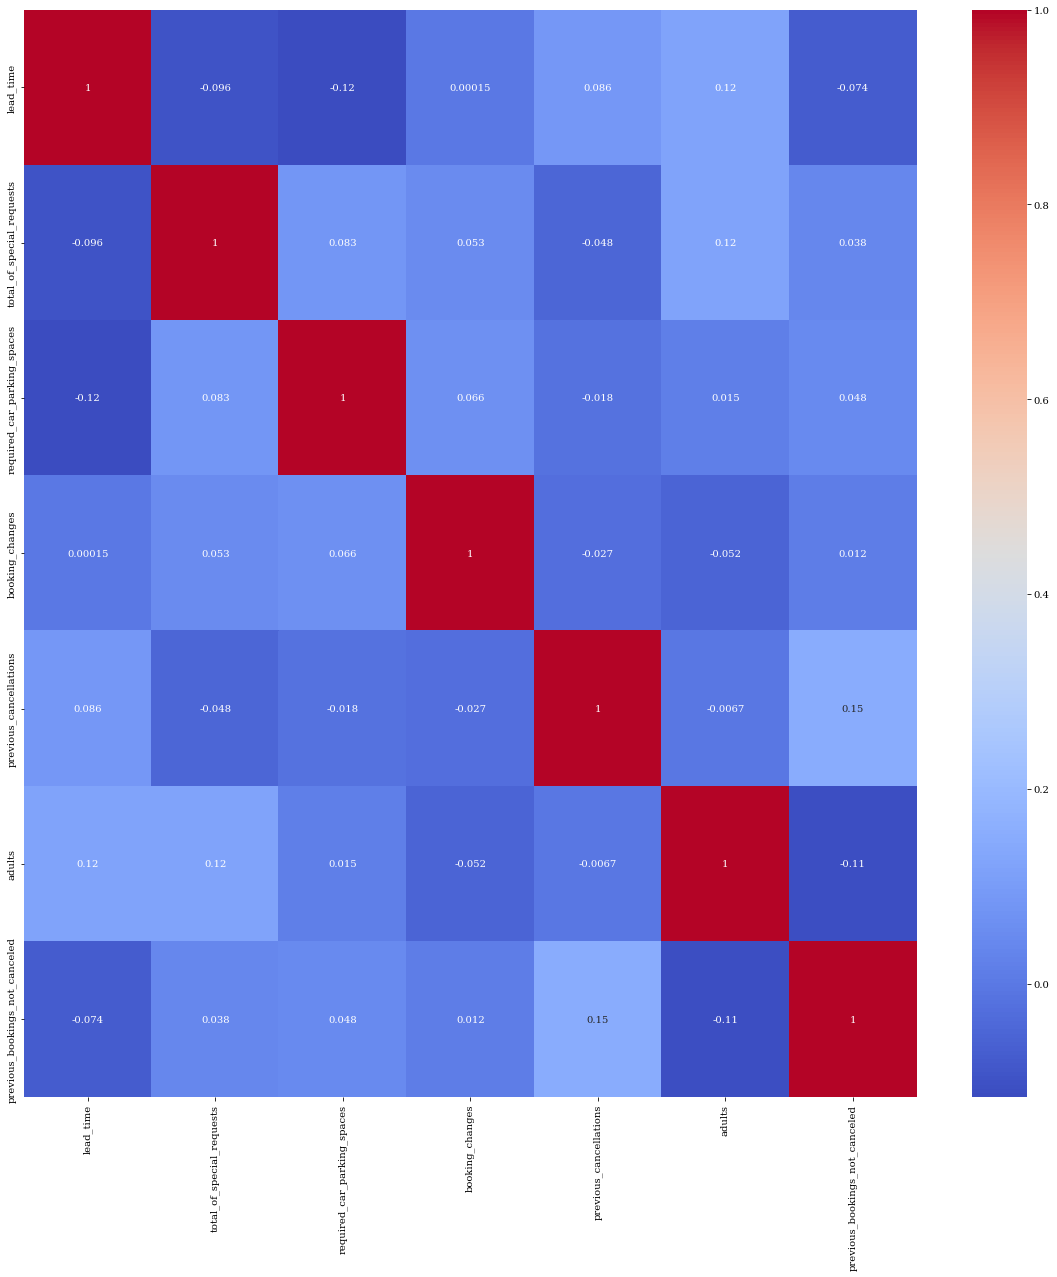

In [81]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_style({'font.family':'serif', 'font.serif':'Times New Roman'})

plt.figure(figsize=(20, 20))
sns.heatmap(X_num.corr(), annot=True, cmap="coolwarm")


Due to the low correlation between numerical features, we decided against the need for PCA.

In [82]:
X = pd.concat([X_cat, X_num], axis=1)
y = df["is_canceled"]

In [83]:
X.shape, y.shape

((119390, 50), (119390,))

## Data splitting

In [84]:
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.model_selection import train_test_split

random_seed = 42
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size = 0.2,
                                                    random_state=random_seed)
X_train_unscaled = X_train
X_test_unscaled = X_test
sc = StandardScaler()
X_train = sc.fit_transform(X_train) # fit sc to X_train and transform X_train
X_test = sc.transform(X_test)       # transform X_test for final evaluation.

X_train = pd.DataFrame(X_train, columns=X.columns)
X_test = pd.DataFrame(X_test, columns=X.columns)

We need to use fit_transform and transform on `X_train` and `X_test` columns with large variance due to the different scale of each column.

It is up for debate whether one-hot encode variables should be scaled, but it has no significant net effect.

# Decision Tree

In [85]:
from sklearn import tree
depth = [20, 30, 40, 50]

train_scores = []
test_scores = []

for max_depth in depth:
    dtree = tree.DecisionTreeClassifier(criterion='entropy',
                                        max_depth=max_depth,
                                        min_samples_leaf=10)
    dtree.fit(X_train, y_train)
    nodes = dtree.tree_.node_count
    train_score = dtree.score(X_train, y_train)
    test_score = dtree.score(X_test, y_test)
    train_scores.append(train_score)
    test_scores.append(test_score)
    print('Depth          :', max_depth)
    print('Node count     :', nodes)
    print('Training score :', train_score)
    print('Testing score  :', test_score)
    print('------------------------------------')

Depth          : 20
Node count     : 5037
Training score : 0.853505318703409
Testing score  : 0.8375073289220203
------------------------------------
Depth          : 30
Node count     : 8641
Training score : 0.8718066839768824
Testing score  : 0.8411508501549544
------------------------------------
Depth          : 40
Node count     : 9103
Training score : 0.8756072535388223
Testing score  : 0.8434123460926376
------------------------------------
Depth          : 50
Node count     : 9109
Training score : 0.8756281933160232
Testing score  : 0.8431610687662283
------------------------------------


In [86]:
dtree_results = pd.DataFrame({
    'Depth': depth,
    'Train': train_scores,
    'Test': test_scores,
})
dtree_results_long = pd.melt(dtree_results,
                             id_vars=['Depth'],
                             value_vars=['Train', 'Test'],
                             var_name='Stage')

fig = px.line(dtree_results_long, x='Depth',
              y='value', color='Stage',
              title='$\\text{Decision Tree } R^2$')

fig.update_layout(
    font_family=FONT,
    title_font_family=FONT,
    yaxis_title='$R^2$',
)

fig.show()

In [87]:
dtree = tree.DecisionTreeClassifier(criterion='entropy',
                                    max_depth=40,
                                    min_samples_leaf=10)
dtree.fit(X_train, y_train)
y_pred = dtree.predict(X_test)

## Evaluation

In [88]:
from sklearn import metrics

def evaluate(y_pred, y_test):
    print(metrics.classification_report(y_test, y_pred))

    conf_matrix = metrics.confusion_matrix(y_test, y_pred)
    print(conf_matrix)
    
    roc = metrics.roc_auc_score(y_test, y_pred)
    matthews = metrics.matthews_corrcoef(y_test, y_pred)
    print("ROC       :",  roc)
    print("Matthews  :",  matthews)
    

In [89]:
evaluate(y_pred, y_test)

              precision    recall  f1-score   support

           0       0.85      0.91      0.88     14907
           1       0.84      0.73      0.78      8971

    accuracy                           0.84     23878
   macro avg       0.84      0.82      0.83     23878
weighted avg       0.84      0.84      0.84     23878

[[13635  1272]
 [ 2462  6509]]
ROC       : 0.820115549087432
Matthews  : 0.661549186683766


Our accuracy with decision trees is **84.3%**.

We also achieve acceptable results for our precision at **83.6%**.

# Logistic Regression

In [90]:
from sklearn import linear_model
C = [1, 0.1, 0.01, 0.001]

num_iters = []
train_scores = []
test_scores = []

for c in C:
    estimator = linear_model.LogisticRegression(C=c,
                                                fit_intercept=False,
                                                max_iter=400)
    estimator.fit(X_train, y_train)
    train_score = estimator.score(X_train, y_train)
    test_score = estimator.score(X_test, y_test)
    num_iters.append(estimator.n_iter_[0])
    train_scores.append(train_score)
    test_scores.append(test_score)
    print(f'Regularization : {c}')
    print(f'Num iterations : {estimator.n_iter_[0]}')
    print(f'Training score : {train_score}')
    print(f'Testing score  : {test_score}')
    print('------------------------------------')

Regularization : 1
Num iterations : 112
Training score : 0.8115420051930647
Testing score  : 0.8115420051930647
------------------------------------
Regularization : 0.1
Num iterations : 93
Training score : 0.8116676438562693
Testing score  : 0.8118351620738755
------------------------------------
Regularization : 0.01
Num iterations : 44
Training score : 0.8111546193148504
Testing score  : 0.8111232096490494
------------------------------------
Regularization : 0.001
Num iterations : 22
Training score : 0.8047156378256135
Testing score  : 0.8074796884161153
------------------------------------


In [91]:
log_reg_results = pd.DataFrame({
    'Regularization': C,
    'Num_Iters': num_iters,
    'Train': train_scores,
    'Test': test_scores,
})
log_reg_results_long = pd.melt(log_reg_results, id_vars=['Regularization'],
                               value_vars=['Train', 'Test'],
                               var_name='Stage')

fig = px.line(log_reg_results_long, x='Regularization',
              y='value', color='Stage', log_x=True,
              title='$\\text{Logistic Regression Classifier } R^2$')

fig.update_layout(
    font_family=FONT,
    title_font_family=FONT,
    yaxis_title='$R^2$',
)

fig.show()

Regularization does not greatly affect the final training or testing coefficient, but it does increase the number of iterations required to converge.

$C=0.01$ is a good compromise.

In [92]:
estimator = linear_model.LogisticRegression(C=0.01,
                                            fit_intercept=False,
                                            solver='lbfgs',
                                            max_iter=400)
estimator.fit(X_train, y_train)

LogisticRegression(C=0.01, class_weight=None, dual=False, fit_intercept=False,
                   intercept_scaling=1, l1_ratio=None, max_iter=400,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [93]:
y_pred = estimator.predict(X_test)

In [94]:
evaluate(y_pred, y_test)

              precision    recall  f1-score   support

           0       0.80      0.93      0.86     14907
           1       0.84      0.62      0.71      8971

    accuracy                           0.81     23878
   macro avg       0.82      0.77      0.79     23878
weighted avg       0.81      0.81      0.80     23878

[[13816  1091]
 [ 3419  5552]]
ROC       : 0.7728479871753005
Matthews  : 0.5897643732356503


Our accuracy with the logisitic regression model is only at **80.1%** compared to our decision tree model. In addition, our recall suffers greatly.

However, our precision is still optimal at **84.8%**.

# Neural Network

In [95]:
import tensorflow as tf
from tensorflow import keras
print(tf.__version__)

2.6.0


## Model 1 - ReLU as activation function

In [96]:
print(X_train.shape)

(95512, 50)


In [97]:
# Hyperparameters
batch_size = 32
epochs = 10
learning_rate = 0.01

inputs = keras.Input(shape=(50,))
x = keras.layers.Dense(64, activation=tf.nn.relu)(inputs)
x = keras.layers.Dense(64, activation=tf.nn.relu)(x)
outputs = keras.layers.Dense(1, activation=tf.nn.sigmoid)(x)

model_1 = keras.Model(inputs, outputs)
model_1.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                metrics=['accuracy'])

In [98]:
model_1.fit(X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            validation_data=(X_test, y_test))

Epoch 1/10
2985/2985 [==============================] - 14s 4ms/step - loss: 0.4682 - accuracy: 0.7841 - val_loss: 0.4208 - val_accuracy: 0.8097
Epoch 2/10
2985/2985 [==============================] - 12s 4ms/step - loss: 0.4133 - accuracy: 0.8102 - val_loss: 0.4015 - val_accuracy: 0.8174
Epoch 3/10
2985/2985 [==============================] - 11s 4ms/step - loss: 0.3966 - accuracy: 0.8177 - val_loss: 0.3894 - val_accuracy: 0.8210
Epoch 4/10
2985/2985 [==============================] - 13s 4ms/step - loss: 0.3863 - accuracy: 0.8224 - val_loss: 0.3810 - val_accuracy: 0.8257
Epoch 5/10
2985/2985 [==============================] - 11s 4ms/step - loss: 0.3792 - accuracy: 0.8262 - val_loss: 0.3756 - val_accuracy: 0.8275
Epoch 6/10
2985/2985 [==============================] - 11s 4ms/step - loss: 0.3741 - accuracy: 0.8283 - val_loss: 0.3745 - val_accuracy: 0.8273
Epoch 7/10
2985/2985 [==============================] - 11s 4ms/step - loss: 0.3700 - accuracy: 0.8305 - val_loss: 0.3686 - val_ac

In [99]:
score = model_1.evaluate(X_test, y_test, batch_size=batch_size, verbose=1)
print('Test loss:     ', score[0])
print('Test accuracy: ', score[1])

747/747 [==============================] - 2s 2ms/step - loss: 0.3646 - accuracy: 0.8340
Test loss:      0.36455971002578735
Test accuracy:  0.834031343460083


In [100]:
# type numpy array
y_score = model_1.predict(X_test)

In [101]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.update_layout(
    font_family=FONT,
    title_font_family=FONT,
)
fig.show()

In [102]:
threshold = 0.5
y_pred = np.where(y_score > threshold, 1, 0)
evaluate(y_pred, y_test)

              precision    recall  f1-score   support

           0       0.82      0.93      0.88     14907
           1       0.86      0.67      0.75      8971

    accuracy                           0.83     23878
   macro avg       0.84      0.80      0.81     23878
weighted avg       0.84      0.83      0.83     23878

[[13936   971]
 [ 2992  5979]]
ROC       : 0.8006718494856868
Matthews  : 0.6411255598050499


## Model 2 - tanh as activation function

In [103]:
# Hyperparameters
batch_size = 32
epochs = 10
learning_rate = 0.01

inputs = keras.Input(shape=(50,))
x = keras.layers.Dense(64, activation=tf.nn.tanh)(inputs)
x = keras.layers.Dense(64, activation=tf.nn.tanh)(x)
outputs = keras.layers.Dense(1, activation=tf.nn.sigmoid)(x)

model_2 = keras.Model(inputs, outputs)
model_2.compile(loss=tf.keras.losses.binary_crossentropy,
                optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate),
                metrics=['accuracy'])

The neural network configuration was chosen after some trial and error.

In [104]:
model_2.fit(X_train, y_train,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1,
            validation_data=(X_test, y_test))

Epoch 1/10
2985/2985 [==============================] - 12s 4ms/step - loss: 0.4582 - accuracy: 0.7894 - val_loss: 0.4241 - val_accuracy: 0.8045
Epoch 2/10
2985/2985 [==============================] - 11s 4ms/step - loss: 0.4201 - accuracy: 0.8084 - val_loss: 0.4065 - val_accuracy: 0.8164
Epoch 3/10
2985/2985 [==============================] - 12s 4ms/step - loss: 0.4059 - accuracy: 0.8144 - val_loss: 0.3958 - val_accuracy: 0.8193
Epoch 4/10
2985/2985 [==============================] - 11s 4ms/step - loss: 0.3966 - accuracy: 0.8181 - val_loss: 0.3889 - val_accuracy: 0.8227
Epoch 5/10
2985/2985 [==============================] - 12s 4ms/step - loss: 0.3899 - accuracy: 0.8201 - val_loss: 0.3831 - val_accuracy: 0.8251
Epoch 6/10
2985/2985 [==============================] - 12s 4ms/step - loss: 0.3842 - accuracy: 0.8228 - val_loss: 0.3809 - val_accuracy: 0.8243
Epoch 7/10
2985/2985 [==============================] - 12s 4ms/step - loss: 0.3797 - accuracy: 0.8256 - val_loss: 0.3776 - val_ac

In [105]:
# type numpy array
y_score = model_2.predict(X_test)
score = model_2.evaluate(X_test, y_test,
                         batch_size=batch_size,
                         verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

747/747 [==============================] - 2s 3ms/step - loss: 0.3687 - accuracy: 0.8312
Test loss: 0.36872848868370056
Test accuracy: 0.8312253952026367


In [106]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(y_test, y_score)

fig = px.area(
    x=fpr, y=tpr,
    title=f'ROC Curve (AUC={auc(fpr, tpr):.4f})',
    labels=dict(x='False Positive Rate', y='True Positive Rate'),
    width=700, height=500
)
fig.add_shape(
    type='line', line=dict(dash='dash'),
    x0=0, x1=1, y0=0, y1=1
)

fig.update_yaxes(scaleanchor="x", scaleratio=1)
fig.update_xaxes(constrain='domain')

fig.update_layout(
    font_family=FONT,
    title_font_family=FONT,
)
fig.show()

In [107]:
y_score = model_2.predict(X_test)

threshold = 0.5

# convert score to actual predictions
y_pred = np.where(y_score > threshold, 1, 0)
evaluate(y_pred, y_test)

              precision    recall  f1-score   support

           0       0.83      0.92      0.87     14907
           1       0.83      0.69      0.75      8971

    accuracy                           0.83     23878
   macro avg       0.83      0.80      0.81     23878
weighted avg       0.83      0.83      0.83     23878

[[13640  1267]
 [ 2763  6208]]
ROC       : 0.8035069764124538
Matthews  : 0.6339382943370165


There is no practical difference between using ReLU and tanh.

Overall, the neural network performs similarly to the decision tree model.

# Random Forest

In [108]:
from sklearn.ensemble import RandomForestClassifier

rforest = RandomForestClassifier(n_estimators=100, random_state=421)

In [109]:
rforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=421,
                       verbose=0, warm_start=False)

In [110]:
y_pred = rforest.predict(X_test)
evaluate(y_pred, y_test)

              precision    recall  f1-score   support

           0       0.87      0.91      0.89     14907
           1       0.83      0.77      0.80      8971

    accuracy                           0.86     23878
   macro avg       0.85      0.84      0.84     23878
weighted avg       0.85      0.86      0.85     23878

[[13498  1409]
 [ 2049  6922]]
ROC       : 0.8385390079885697
Matthews  : 0.687990435196173


In [111]:
from sklearn.model_selection import GridSearchCV

n_estimators = [100,200]
max_features = ['sqrt']
max_depth = [2,3,7]
min_samples_split = [2,3,4]
min_samples_leaf = [2,3,4]
bootstrap = [False]

param_grid = {
    'n_estimators': n_estimators,
    'max_features': max_features,
    'max_depth': max_depth,
    'min_samples_split': min_samples_split,
    'min_samples_leaf': min_samples_leaf,
    'bootstrap': bootstrap
}

gs = GridSearchCV(rforest, param_grid, cv=3, verbose=1, n_jobs=20)
gs.fit(X_train, y_train)
rfc_3 = gs.best_estimator_
gs.best_params_

Fitting 3 folds for each of 54 candidates, totalling 162 fits


[Parallel(n_jobs=20)]: Using backend LokyBackend with 20 concurrent workers.
[Parallel(n_jobs=20)]: Done  10 tasks      | elapsed:   54.0s
[Parallel(n_jobs=20)]: Done 162 out of 162 | elapsed:  9.2min finished


{'bootstrap': False,
 'max_depth': 7,
 'max_features': 'sqrt',
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 100}

In [112]:
# Random Forest with best hyper params
rforest = RandomForestClassifier(criterion='entropy',
                                 max_depth=15,
                                 n_estimators=100,
                                 max_features='sqrt',
                                 min_samples_leaf=2,
                                 min_samples_split=2)
rforest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='entropy', max_depth=15, max_features='sqrt',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=2, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

## Stacking

In [113]:
# Stacking
# Take best params for all models used
# 1. Decision Tree
dtree

# 2. Logistic Regression
estimator

# 3. Random Forest
rforest

# Start building the stack
estimators = [
    ('dtree', dtree),
    ('rforest', rforest),
    ('estimator', estimator)
]

# Build the stack model
stack_model = StackingClassifier(
  estimators=estimators, final_estimator=LogisticRegression()
)

stack_model.fit(X_train,y_train)

# Predict
y_pred = stack_model.predict(X_test)

In [114]:
evaluate(y_pred, y_test)

              precision    recall  f1-score   support

           0       0.85      0.92      0.88     14907
           1       0.85      0.74      0.79      8971

    accuracy                           0.85     23878
   macro avg       0.85      0.83      0.84     23878
weighted avg       0.85      0.85      0.85     23878

[[13699  1208]
 [ 2358  6613]]
ROC       : 0.8280586468490477
Matthews  : 0.6770701887406936
